## Audio diffusion using latent DDIM diffusion

This works by taking samples from the latent space of the model using a different seed. 

We can then interpolate between samples, however randomly sampling from latent space makes it difficult to find audio that sounds good. 

Perhapse experiment with clustering or finding clusters? 

Also chaging the seed could be an interesting control

In [1]:
import torch
import matplotlib.pyplot as plt
import random
import threading
from librosa.beat import beat_track
from pythonosc import dispatcher, osc_server
import numpy as np
from datasets import load_dataset
from diffusers_local import DiffusionPipeline, DDIMScheduler, AudioDiffusionPipeline, AutoencoderKL, Mel, UNet2DModel
import soundfile as sf
from CreateDataset import AudioProcessor
from NetworkBending import NetworkBending
from MelVocoder import MelVocoder
import time

osc_lock = threading.Lock()

NB = NetworkBending()

device = "cuda" if torch.cuda.is_available() else "cpu"

vocoder = MelVocoder(device_name=device) 

# apply the custom unet model so we can Networkbend the audio
unet = UNet2DModel.from_pretrained("teticio/latent-audio-diffusion-512", subfolder="unet")
#set the scheduler to DDIM
scheduler = DDIMScheduler.from_pretrained("teticio/latent-audio-diffusion-512", subfolder="scheduler")
#set the vqvae
vqvae = AutoencoderKL.from_pretrained("teticio/latent-audio-diffusion-512", subfolder="vqvae")

mel = Mel()

audio_diffusion = AudioDiffusionPipeline(
    vqvae=vqvae, 
    unet=unet,
    mel=mel,
    vocoder=vocoder,
    scheduler=scheduler,
)

#load the model to the GPU/CPU
audio_diffusion.to(device)

#define the vae so we can access the latent space
vae = audio_diffusion.vqvae



print(audio_diffusion)

alpha = 0
latent1 = 0
latent2 = 1
diffusion_steps = 10
make_loop = 0
generate = 1


c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn

RuntimeError: Error(s) in loading state_dict for Generator_melgan:
	size mismatch for model.1.weight_v: copying a param with shape torch.Size([512, 80, 7]) from checkpoint, the shape in current model is torch.Size([512, 256, 7]).

In [2]:
import numpy as np
from PIL import Image

# Load the spectrogram image
image_path = 'generated_image.png'
image = Image.open(image_path).convert("L")  # Convert to grayscale if needed

# Convert the image to a NumPy array
spectrogram_array = np.array(image)

# Calculate mean and std for each frequency bin (axis=1 is time)
mean = np.mean(spectrogram_array, axis=1)  # Shape (512,)
std = np.std(spectrogram_array, axis=1)    # Shape (512,)

# Save these values for normalization in MelGAN
np.save("data/drumbeats_1bar/mean_512.mel.npy", mean)
np.save("data/drumbeats_1bar/std_512.mel.npy", std)

print("Normalization files saved with shape:", mean.shape)



Normalization files saved with shape: (256,)


In [2]:
# Load audio and process it into 5 second spectrograms
input_dir = r"C:\\Users\\danhearn\\Music"
processor = AudioProcessor(input_dir)
processor.process_directory()

An error occurred while trying to fetch teticio/latent-audio-diffusion-512: teticio/latent-audio-diffusion-512 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Saved mel spectrogram: chunk_1_93a198ea-3fb4-4119-95d7-401bc279d558.png
Saved mel spectrogram: chunk_10_6e7202df-9aee-4701-98c9-bbfc65305114.png
Saved mel spectrogram: chunk_11_dc361187-e7ca-4abc-b62f-52dd2101ed4a.png
Saved mel spectrogram: chunk_12_68e7cbca-6abf-4b57-8b68-a0dee7654ba9.png
Saved mel spectrogram: chunk_13_36299a60-a084-4729-9ab2-5b5d7d388785.png
Saved mel spectrogram: chunk_14_f1b65878-6f52-46e3-9ea0-67431903b0cf.png
Saved mel spectrogram: chunk_15_454c1a08-8ba2-45bc-84f2-bf62d74752fb.png
Saved mel spectrogram: chunk_16_4c5a7be4-b4cf-43b5-9501-64bea44b2dd0.png
Saved mel spectrogram: chunk_17_35aff5ff-f9c0-4b51-82a5-695a3d94546e.png
Saved mel spectrogram: chunk_18_1e7b9ab4-5b2c-47d7-ac13-aba7ff17438e.png
Saved mel spectrogram: chunk_19_ae103697-454c-473b-920e-8b1a91b340c8.png
Saved mel spectrogram: chunk_2_7825aa75-ee22-4ae1-a403-9e972d7848bf.png
Saved mel spectrogram: chunk_20_0a5da4bb-504e-46a5-a0bd-d4349c636ba5.png
Saved mel spectrogram: chunk_21_7d0a5e1c-f32d-411d-80

In [3]:
#encode images in latent space
decoded_images = []

for i in range(10):
    generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 1000))
    decoded_images.append(
        torch.randn(
            (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1]),
            generator=generator,
            device="cuda")
    )


C:\Users\danhearn\AppData\Local\Temp\ipykernel_42780\710911740.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1]),


In [12]:
import torch
from torchvision import transforms
from PIL import Image

# Define preprocessing transformations (adjust based on your model's requirements)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Reshape to the VAE's input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalization, adjust if necessary
])

# Load and preprocess spectrogram images
def load_and_preprocess_image(path):
    image = Image.open(path).convert("L")
    return preprocess(image)

# Assuming you have a list of paths to your spectrogram images
spectrogram_paths = ["data\mel_spectrograms\chunk_1_7b6bd30c-1187-46d8-8c98-88c45df4349b.png", "data/mel_spectrograms/chunk_1_26df98a1-90e4-4747-a5fb-4523283a9118.png","data\mel_spectrograms\chunk_1_e897576e-8648-4e12-aea4-2e04e7403e5a.png", "data\mel_spectrograms\chunk_3_b59e23d2-ef67-4c23-bb0e-4e8937fca5c1.png"]
spectrograms = torch.stack([load_and_preprocess_image(p) for p in spectrogram_paths])

# Send spectrograms to the appropriate device
spectrograms = spectrograms.to(device)
spectrograms.shape


torch.Size([4, 1, 256, 256])

In [5]:
with torch.no_grad():
    latent_vectors = vae.encode(spectrograms).latent_dist.mean  # Mean of the distribution

c:\Users\danhearn\Documents\GitHub\diffusertrack\diffusers_local\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


In [6]:
# Assuming vae and preprocess are defined as before
latent_vectors = []

for path in spectrogram_paths:
    # Preprocess the image
    spectrogram = load_and_preprocess_image(path).unsqueeze(0).to(device)  # Add batch dimension
    
    # Encode to latent vector
    with torch.no_grad():
        latent_vector = vae.encode(spectrogram).latent_dist.mean  # Get the mean of the latent distribution
    
    # Flatten latent vector and add to list
    latent_vectors.append(latent_vector.view(-1))  # Flatten to 1D

# Stack latent vectors to form a 2D tensor suitable for clustering
latent_vectors = torch.stack(latent_vectors)


In [7]:
from sklearn.cluster import KMeans

# Specify the number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the clustering model to the latent vectors
cluster_labels = kmeans.fit_predict(latent_vectors.cpu().numpy())


c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


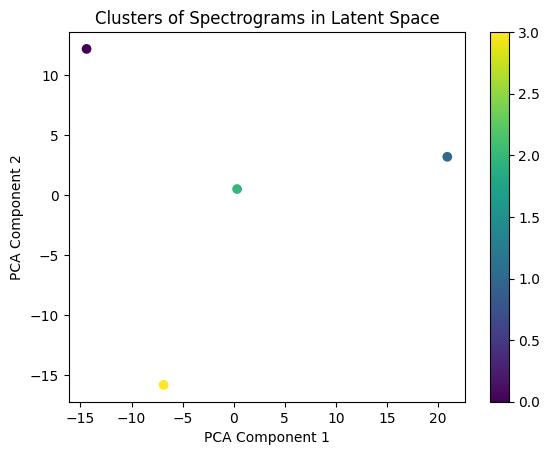

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors.cpu().numpy())

# Plot clusters
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters of Spectrograms in Latent Space")
plt.colorbar()
plt.show()


In [ ]:
# Choose a latent vector from Cluster 1
cluster_1_indices = [i for i, label in enumerate(cluster_labels) if label == 0]  # Adjust to select the desired cluster
latent1 = latent_vectors[cluster_1_indices[0]]  # Use the first vector in Cluster 1
# Ensure the latent vector matches the unet input requirements
latent1 = latent1.view(1, audio_diffusion.unet.config.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1])

RuntimeError: shape '[1, 1, 512, 512]' is invalid for input of size 1024

In [14]:
# Choose a latent vector from Cluster 1
cluster_2_indices = [i for i, label in enumerate(cluster_labels) if label == 3]  # Adjust to select the desired cluster
latent2 = latent_vectors[cluster_2_indices[0]]  
# Ensure the latent vector matches the unet input requirements
latent2 = latent2.view(1, audio_diffusion.unet.config.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1])

RuntimeError: shape '[1, 1, 64, 64]' is invalid for input of size 1024

C:\Users\danhearn\AppData\Local\Temp\ipykernel_42780\3703998157.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0],
100%|██████████| 100/100 [00:02<00:00, 42.43it/s]

Sample shape adjusted to torch.Size([1, 1, 512, 512])
Sample shape adjusted to torch.Size([1, 1, 80, 512])
Audio output shape: torch.Size([1, 1, 131072])


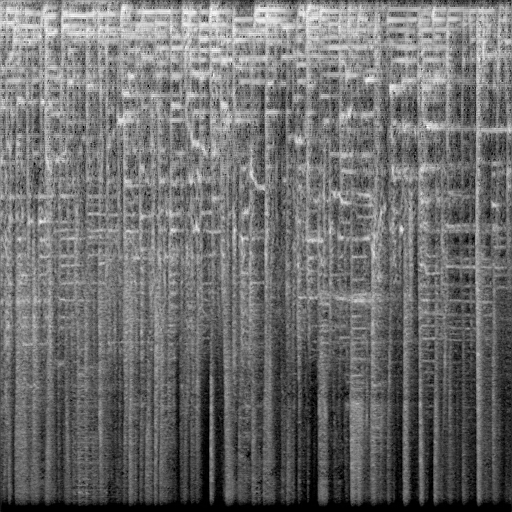

In [21]:
from IPython.display import display, Audio

generator = torch.Generator(device="cuda").manual_seed(42)

noise = torch.randn(
    (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0],
     audio_diffusion.unet.sample_size[1]),
    generator=generator,
    device=device)

alpha = 0.1  #@param {type:"slider", min:0, max:1, step:0.1}


output = audio_diffusion(steps=100,
    noise=noise,
    generator=generator)
display(output.images[0])
display(Audio(output.audios[0], rate=11025))